In [1]:
import time
from itertools import groupby

# supress unnecessary warnings so the notebook looks clean
import warnings
warnings.filterwarnings('ignore')

# import libraries to quickly analyze data
import numpy as np
import pandas as pd
from scipy import signal, stats
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 999)
pd.set_option('precision', 4)
pd.options.mode.chained_assignment = None  # default='warn'

# import plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
p = sns.color_palette()

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# read-in the training data
with pd.HDFStore("datasets/train.h5", "r") as train:
    df = train.get("train")
    
# memory usage
print('Memory consumption for train data, Mb: {:.2f}'.format(df.memory_usage().sum()/2**20))

Memory consumption for train data, Mb: 730.91


## Data Analysis

### 1. Feature Engineering

In [3]:
cols = [0, 0, 0]
for c in df.columns:
    if 'derived' in c: cols[0] += 1
    if 'fundamental' in c: cols[1] += 1
    if 'technical' in c: cols[2] += 1
        
print('Derived columns: {}, Fundamental columns: {}, Technical columns: {}'.format(*cols))
print('\nColumn dtypes:')
print(df.dtypes.value_counts())
print('\nint16 columns:')
print(df.columns[df.dtypes == 'int16'])

Derived columns: 5, Fundamental columns: 63, Technical columns: 40

Column dtypes:
float32    109
int16        2
dtype: int64

int16 columns:
Index(['id', 'timestamp'], dtype='object')


Here we can see that we have 111 columns, of which the only ones with integer values are the IDs and the timestamp. The other features are split into three categories, which we will look at in more detail later. Let's look at the target value first.

#### $\star$ Timestamp variable

In [4]:
# how many periods
len(df.timestamp.unique()) 

1813

Looks like we are tracking across 1,813 time periods. We can't make any assumptions about the time period length - it could be days, hours, minutes, etc. as long as the period is uniform.

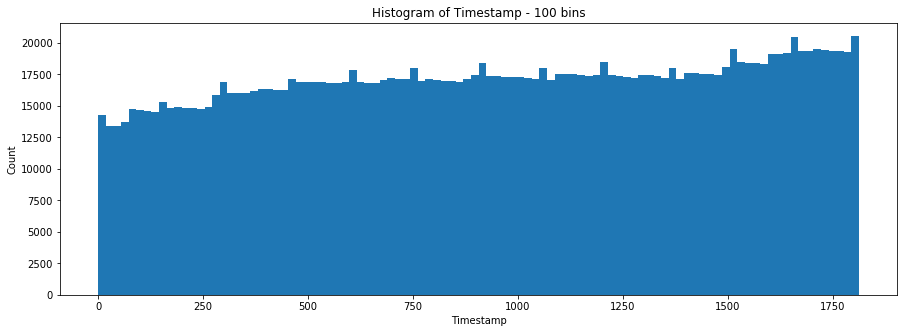

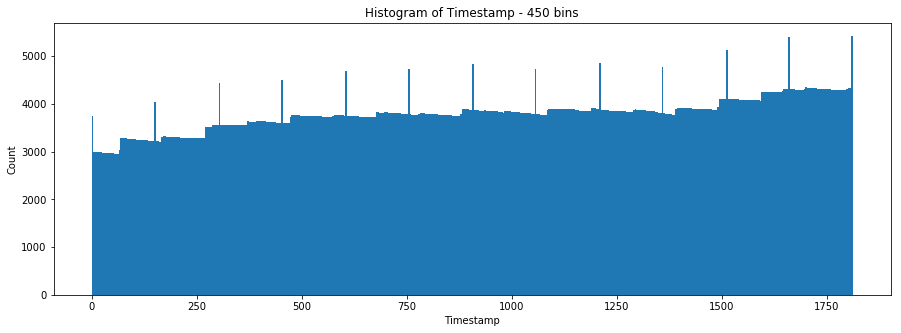

In [5]:
timestamp = df.timestamp.values
for bins in [100, 450]:
    plt.figure(figsize=(15, 5))
    plt.hist(timestamp, bins=bins)
    plt.xlabel('Timestamp')
    plt.ylabel('Count')
    plt.title('Histogram of Timestamp - {} bins'.format(bins))

Now this is very interesting. There appears to be quite a complex structure to the timestamp variable over time. Maybe we can unravel something from it, and maybe figure out what the real-life time period is.

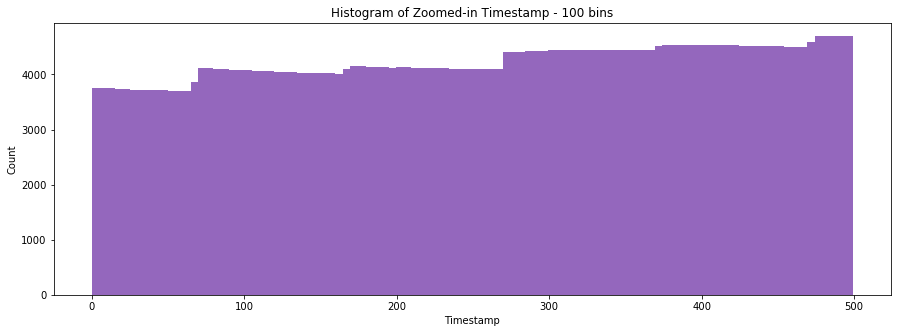

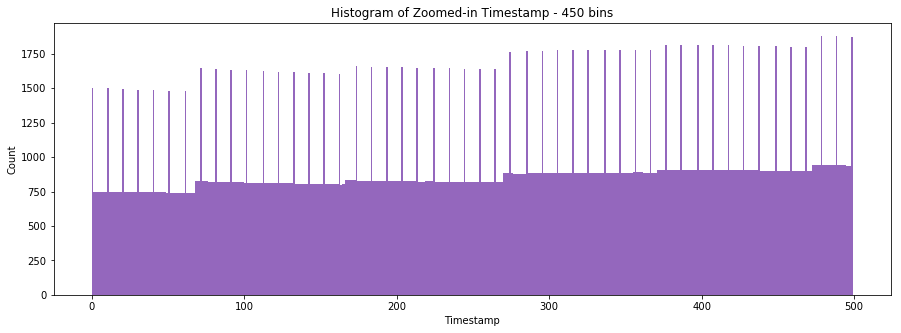

In [6]:
time_mini = df.timestamp.loc[df.timestamp < 500].values
for bins in [100, 450]:
    plt.figure(figsize=(15, 5))
    plt.hist(time_mini, bins=bins, color=p[4])
    plt.xlabel('Timestamp')
    plt.ylabel('Count')
    plt.title('Histogram of Zoomed-in Timestamp - {} bins'.format(bins))

I can see here that the count of timestamp tends to decrease slightly for about 100 'timestamps', and then jumps up afterwards. My hypothesis is that this jump could signify the start of the next day or similar. Let's try to look at these jumps in more detail.

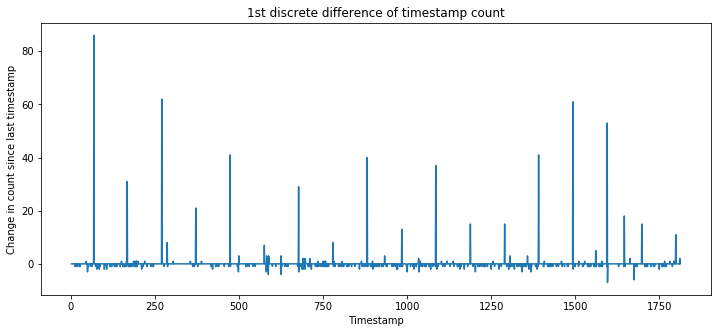

In [7]:
timediff = df.groupby('timestamp')['timestamp'].count().diff()
plt.figure(figsize=(12, 5))
plt.plot(timediff)
plt.xlabel('Timestamp')
plt.ylabel('Change in count since last timestamp')
plt.title('1st discrete difference of timestamp count')

Okay, there's definitely some structure here. Let's measure the distance between the peaks, defining a peak as a point where the count increases by more than 10.

In [8]:
pd.Series(timediff[timediff > 10].index).diff()

0       NaN
1      99.0
2     103.0
3     101.0
4     102.0
5     204.0
6     204.0
7     103.0
8     101.0
9     103.0
10    102.0
11    101.0
12    102.0
13    102.0
14     51.0
15     52.0
16    101.0
Name: timestamp, dtype: float64

This basically confirms that the timestamp has a time period of 100. We can see that almost all the peaks are 100 timestamps apart, with two of them being 200 timestamps apart, and two of them being 50 timestamps apart. Looking at the graph above, we can also see that in the two cases where the period is 200, there is actually a peak 100 timestamps in which is smaller than 100.

In [9]:
print(timediff[timediff > 10].index[0])

68


We can approximate where the peaks will be with a function 100x + 68 (there is a gap of 100 between each peak, with an offset of 68.) This information could be used to quite accurately predict what the count of the timestamp will be in the future.

#### $\star$ Target variable, y

Target value min -0.086 max 0.093 mean 0.000 std 0.022


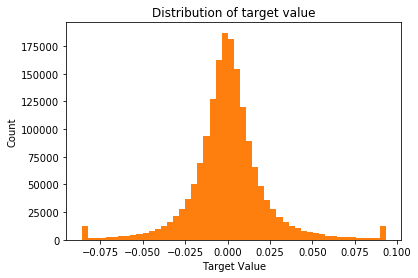

In [10]:
y = df['y'].values
plt.hist(y, bins=50, color=p[1])
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of target value')

print('Target value min {0:.3f} max {1:.3f} mean {2:.3f} std {3:.3f}'\
          .format(np.min(y), np.max(y), np.mean(y), np.std(y)))

So we have what looks like a target value which is normally distributed around a mean of (exactly) 0 with a standard deviation of .022. Interestingly, there is a small peak at the start and end of the distribution.

In [11]:
print('Number of unique target values: {}'.format(len(set(y))))

Number of unique target values: 1672946


Looks like almost all of the target values that we see here are unique to only that row. It doesn't look like any binning has occured here - I was half expecting the peaks at the start and end of the distribution to be a single value, a number which signified "out of bounds".

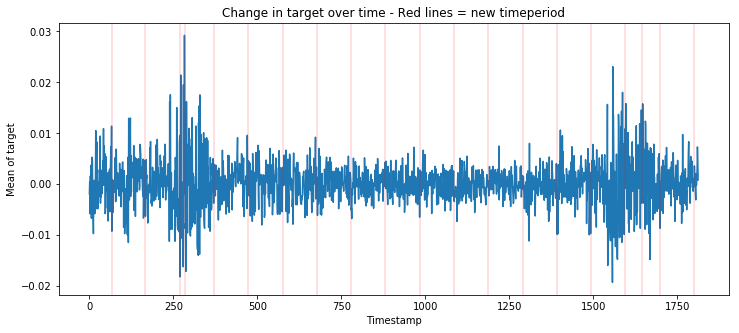

In [12]:
# change in the target value over time
time_targets = df.groupby('timestamp')['y'].mean()
plt.figure(figsize=(12, 5))
plt.plot(time_targets)
plt.xlabel('Timestamp')
plt.ylabel('Mean of target')
plt.title('Change in target over time - Red lines = new timeperiod')
for i in timediff[timediff > 5].index:
    plt.axvline(x=i, linewidth=0.25, color='red')

There doesn't seem to be too much of a pattern to the target value, except for those two, very apparent, peaks in variability. It looks like the time series aspect will be very important. It also appears to me that the start of a new time period very often coincides with (at least a small) peak in the data. 

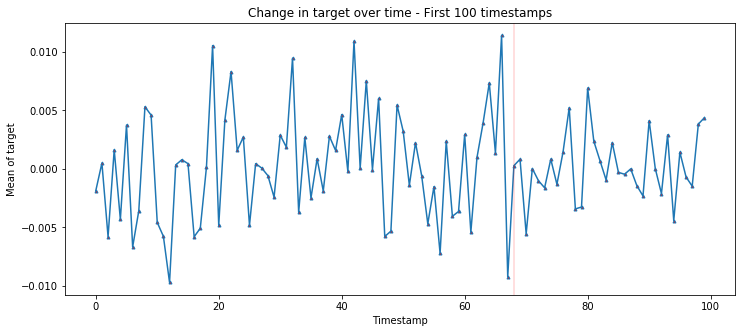

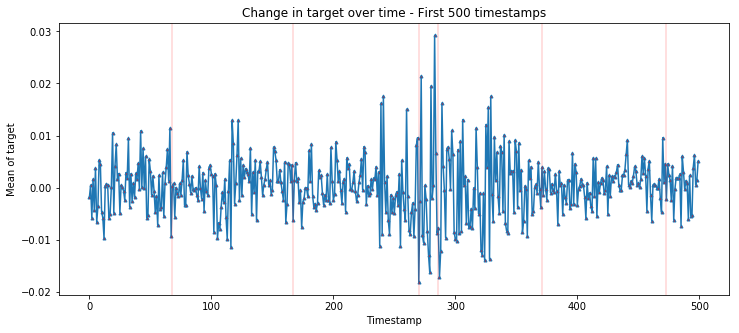

In [13]:
for i in [100, 500]:
    time_targets = df.groupby('timestamp')['y'].mean()[:i]
    plt.figure(figsize=(12, 5))
    plt.plot(time_targets, color=p[0], marker='^', markersize=3, mfc='red')
    plt.xlabel('Timestamp')
    plt.ylabel('Mean of target')
    plt.title('Change in target over time - First {} timestamps'.format(i))
    for i in timediff[:i][timediff > 5].index:
        plt.axvline(x=i, linewidth=0.25, color='red')

In [14]:
# finding distributions of the result
time_targets_2 = df[['timestamp', 'y']].groupby('timestamp').agg([np.mean, np.std, len]).reset_index()
time_targets_2.head()

timestamp       y               
               mean     std    len
0         0 -0.0019  0.0266  750.0
1         1  0.0005  0.0284  750.0
2         2 -0.0058  0.0293  750.0
3         3  0.0016  0.0253  750.0
4         4 -0.0043  0.0359  750.0

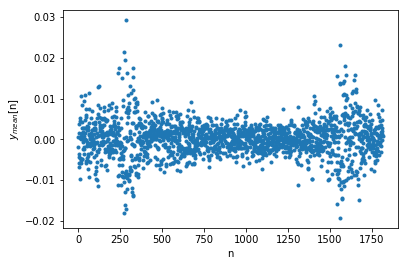

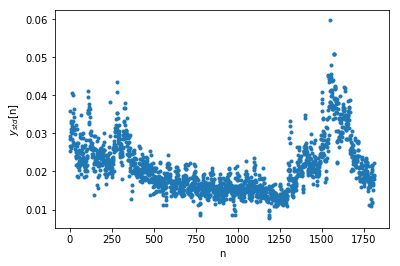

In [15]:
n = time_targets_2['timestamp']
yMean = np.array(time_targets_2['y']['mean'])
yStd = np.array(time_targets_2['y']['std'])

plt.figure()
plt.plot(n, yMean, '.')
plt.xlabel('n')
plt.ylabel('$y_{mean}$[n]')

plt.figure()
plt.plot(n, yStd, '.')
plt.xlabel('n')
plt.ylabel('$y_{std}$[n]')

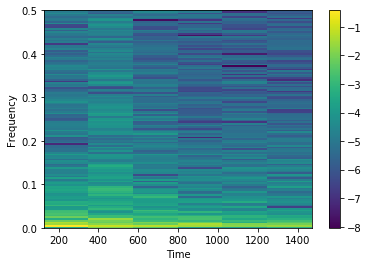

In [16]:
yMeanCumsum = np.cumsum( yMean )
f, t, Syy = signal.spectrogram(yMeanCumsum)

plt.figure()
plt.pcolormesh(t, f, np.log10(Syy))
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()

The cumulative sum seems to be increasing linearly. Is there something there??? I need to find a linear trend and see of there is something that can be obtained form there. 

In [17]:
# remember that the training contains timestamps upto 905
np.mean(yMean), np.mean(df['y']), np.mean(df['y'][df.timestamp < 906])

(0.00021821978, 0.00022175087360665202, 0.000255877006566152)

This means that the mean of y is greater than zero. This is great. This tells us that the slope overall should be positive. 

#### $\star$  Id variable

Some features per id can be clustered into groups that perform the same kind of time evolution. Unfortunately a unique feature does not perform the same dynamics for different ids. But maybe there are groups of ids that have identical or similar features and perhaps this groups can give some insights into the "global" dynamics.

Assumptions:

- NaN values make sense. An id that has always NaNs for a specific feature has no relationship with it.
- Id's live in different time-zones (and have different lifetimes)

First, There are a lot of ids having a large number of timestamps and maybe they could give more insights into the time evolution and dynamics of features. Perhaps one could also find id-groups of same lifetimes with similar behavior.

In [18]:
lifetimes = df.groupby('id').apply(len)
lifetimes = lifetimes.sort_values(ascending=False)
lifetimes = lifetimes.reset_index()
lifetimes.columns = ["id", "duration"]
lifetimes.head()

,id,duration
0,1066,1813
1,704,1813
2,697,1813
3,699,1813
4,1548,1813


In [19]:
# let's collect all id's that have a lifetime of 1813
long_lifetime_ids = lifetimes[lifetimes["duration"] == 1813]
long_lifetime_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 526
Data columns (total 2 columns):
id          527 non-null int64
duration    527 non-null int64
dtypes: int64(2)
memory usage: 12.4 KB


There are 527 ids with a lifetime of 1813 timestamps. As I want to study the feature dynamics of id's that behave the same way, I need to find all those id's that share the same features (and nan-structures). Let's do this by a simple approach: Select one example id of the dataframe "long_lifetimes_ids" and find all ids in that frame that match its feature-presence (nan-structure).

I will be careful with binary transformations because a nan-value may not be present all over the time of my selected id and perhaps 0.0 is the first value that occurs in the situation where "nan" changes to a value. Instead, I will do the following:

- Kick out features that have a permanent nan-structure over all 1813 timestamps
- Keep features with partial present nan-structures, but collect their labels for safety

In [20]:
long_lifetime_ids.head()

,id,duration
0,1066,1813
1,704,1813
2,697,1813
3,699,1813
4,1548,1813


In [21]:
def find_nan_structure(instrument, data):
    data_id = data.loc[data["id"]==instrument,:]
    no_nan_features = []
    partial_nan_features = []
    total_nan_features = [] 
    for col in data_id.columns:
        if col not in ["id", "timestamp", "y"]:
            nr_nans = pd.isnull(data_id[col]).sum()
            if (nr_nans == 0):
                no_nan_features.append(col)
            elif (nr_nans == len(data_id[col])):
                total_nan_features.append(col)
            else:
                partial_nan_features.append(col)
    return no_nan_features, total_nan_features, partial_nan_features

# By playing around, I found out that id 704 belongs to a large group of ids that share the same features.
no_nan, total_nan, partial_nan = find_nan_structure(704, df)

In [22]:
def find_id_group(instrument, data, lifetime_ids):
    strong_cluster = []
    soft_cluster = []
    no_nan, total_nan, partial_nan = find_nan_structure(instrument, data)
    no_nan_soft = set(no_nan).union(partial_nan)
    for element_id in lifetime_ids:
        no_nan_e, total_nan_e, partial_nan_e = find_nan_structure(element_id, data)
        no_nan_soft_e = set(no_nan_e).union(partial_nan_e)
        if set(no_nan_soft_e) == set(no_nan_soft):
            soft_cluster.append(element_id)
        if set(no_nan_e) == set(no_nan):
            strong_cluster.append(element_id)
    return strong_cluster, soft_cluster

strong_cluster, soft_cluster = find_id_group(704, df, long_lifetime_ids.id)

In [23]:
strong_cluster[:5]

[704, 711, 719, 684, 1485]

I will proceed with the strong-cluster group of id 704. Let's create a dataframe which contains only these ids and let's try to find correlated features or do some other stuff.

In [24]:
cluster_data = df[df["id"].isin(strong_cluster)]
cluster_data.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_7,fundamental_8,fundamental_9,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,fundamental_18,fundamental_19,fundamental_20,fundamental_21,fundamental_22,fundamental_23,fundamental_24,fundamental_25,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_32,fundamental_33,fundamental_34,fundamental_35,fundamental_36,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_41,fundamental_42,fundamental_43,fundamental_44,fundamental_45,fundamental_46,fundamental_47,fundamental_48,fundamental_49,fundamental_50,fundamental_51,fundamental_52,fundamental_53,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_58,fundamental_59,fundamental_60,fundamental_61,fundamental_62,fundamental_63,technical_0,technical_1,technical_2,technical_3,technical_5,technical_6,technical_7,technical_9,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,technical_18,technical_19,technical_20,technical_21,technical_22,technical_24,technical_25,technical_27,technical_28,technical_29,technical_30,technical_31,technical_32,technical_33,technical_34,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
28,87,0,0.0455,0.0544,0.3302,-0.8170,0.0126,-0.0365,-0.1152,-0.2374,0.2878,0.1027,0.4279,-0.1518,-0.0871,-0.6278,0.0083,-0.2175,2.8390,-0.0959,0.0297,-0.1478,0.2562,1.0348,-0.2937,2.9018,-0.1729,1.1055,0.5948,0.4180,0.1348,-0.1801,-0.2658,0.7376,-0.0081,1.4839,0.0061,0.0892,-1.0431,0.8888,0.0902,-0.2283,-0.3588,0.1224,0.0332,-0.0603,-0.4880,0.4515,0.5552,1.4940,1.6500,0.1637,-0.0526,0.0810,-0.4131,-0.0620,0.4542,0.1471,-0.1627,-0.3235,0.4337,-0.2596,-0.2320,-0.2805,-0.3524,1.0515,0.1989,-0.1656,0.4400,0.0245,NaN,NaN,0.0,NaN,NaN,-2.0,0.5188,NaN,-2.0,0.0,NaN,0.0000,-2.0,NaN,0.0,NaN,-0.8748,0.000,-0.7882,0.5,NaN,NaN,-0.8649,NaN,-2.0,0.0263,NaN,NaN,NaN,0.5,1.7657,0.8071,NaN,NaN,NaN,1.5588,NaN,NaN,0.0,NaN,0.0308
43,124,0,0.0150,-0.0207,-0.0081,4.6382,0.1082,-0.2511,0.1435,0.0327,-0.1890,-0.1151,-0.0118,-0.0670,-0.0121,-0.0365,-0.0187,0.1159,0.0449,0.6109,-0.0402,0.2017,-0.0611,-0.0056,0.1112,0.0596,-0.0832,-0.0497,-0.0754,-0.1360,0.0567,0.1205,0.0295,0.0252,0.2419,0.1007,-0.2739,0.1691,0.0594,-0.1217,-0.1080,-0.1641,-0.1332,0.1414,-0.0900,0.1079,-0.3061,0.0022,0.0003,-0.0148,0.0107,0.0691,0.1433,-0.1269,-0.1125,0.0370,-0.0918,0.0496,-0.1202,0.0744,-0.1807,0.0591,-0.0039,-0.0253,-0.2250,0.0033,-0.0658,-0.0240,0.1429,-0.0178,NaN,NaN,-2.0,NaN,NaN,-2.0,-0.3170,NaN,0.0,-2.0,NaN,0.0000,-2.0,NaN,-2.0,NaN,0.4008,0.006,0.3452,-0.5,NaN,NaN,0.4539,NaN,0.0,0.0000,NaN,NaN,NaN,-0.5,-0.0277,0.2949,NaN,NaN,NaN,-0.3697,NaN,NaN,-2.0,NaN,-0.0038
55,160,0,0.0778,-0.0028,0.1463,-0.1633,0.5710,0.2507,0.2517,1.4349,0.3027,-0.1358,0.0779,-0.2034,0.3738,-0.1180,-0.0681,1.9804,-0.0073,1.1416,-0.0918,0.2767,-0.0430,0.2049,-0.1673,0.3214,-0.0640,0.3407,0.0862,0.0315,0.3505,0.0863,-0.2365,0.3467,4.2514,0.0531,0.0198,2.8568,0.0251,-0.0327,0.0196,-0.2246,-0.1610,0.0239,0.2531,0.2009,-0.1293,0.0477,0.0646,-0.0923,0.5623,0.0488,-0.0928,-0.2418,-0.1508,-0.0100,0.5477,0.3768,-0.0382,-0.2160,0.6071,1.3055,0.8405,-0.2676,-0.1034,-0.0771,-0.1393,-0.1554,0.0000,-0.1104,NaN,NaN,-2.0,NaN,NaN,0.0,-0.3319,NaN,0.0,-2.0,NaN,0.0038,-2.0,NaN,-2.0,NaN,-0.0708,0.000,-0.0926,-0.5,NaN,NaN,0.4566,NaN,-2.0,0.0000,NaN,NaN,NaN,0.5,1.2875,0.9133,NaN,NaN,NaN,-0.2839,NaN,NaN,-2.0,NaN,-0.0126
62,184,0,0.0261,-0.0119,0.0931,3.7206,-0.3468,0.0096,0.2944,0.0661,-0.0144,-0.0956,0.0130,-0.1058,-0.0464,-0.1686,-0.0682,0.1635,0.0103,0.2225,-0.0396,0.0301,-0.2481,-0.0855,0.1443,-0.0620,-0.0840,-0.0567,0.4157,0.2638,-0.3031,0.2192,-0.1281,0.1940,0.4693,-0.0011,-0.1019,0.2439,0.4398,-0.0289,-0.0439,-0.2051,0.0372,0

Let's select a feature, which does not contain nan-values, for playing around.

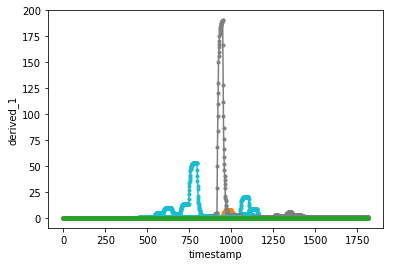

In [25]:
test_feature = no_nan[1]
plt.figure()
for instrument in strong_cluster:
    plt.plot(cluster_data[cluster_data["id"]==instrument].timestamp, 
             cluster_data[cluster_data["id"]==instrument][test_feature].values, '.-')
plt.xlabel("timestamp")
plt.ylabel(test_feature)

In [26]:
def find_id_groups(data, idlist, feature, limit):
    groups = []
    singles = []
    for list_instrument in idlist:
        group = []
        for next_instrument in idlist:
            coeff = np.corrcoef(data.loc[data.id==list_instrument, feature].values, 
                                data.loc[data.id==next_instrument, feature].values)[0,1]
            coeff = np.round(coeff, decimals=2)
            if coeff >= limit:
                group.append(next_instrument)
        for member in group:
            while member in idlist:
                idlist.remove(member)
        if len(group) > 1:
            groups.append(group)
        elif len(group) == 1:
            singles.append(list_instrument)
    return groups, singles

id_list = strong_cluster[:]
groups, singles = find_id_groups(cluster_data, id_list, test_feature, 0.80)
groups

[[704, 1448, 1393, 235],
 [719, 920, 913],
 [1485, 452],
 [657, 1407],
 [1075, 348],
 [1103, 160, 1970, 265],
 [892, 349],
 [728, 901, 1724, 510],
 [1921, 1901],
 [1395, 2079, 287, 507]]

Found a pattern again! Just by looking at linear correlations, we can find that different features of one id are correlated but also that values of a specific feature of different ids are correlated in some cases. Let's have a look at those groups.

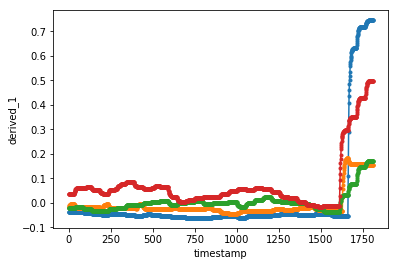

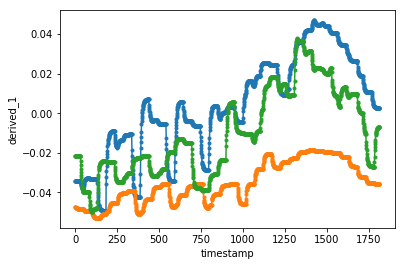

In [27]:
for group in groups[:2]:
    plt.figure()
    for instrument in group:
        plt.plot(cluster_data[cluster_data.id==instrument]["timestamp"].values, 
                 cluster_data[cluster_data.id==instrument][test_feature].values, '.-')
    plt.xlabel("timestamp")
    plt.ylabel(test_feature)

### 2. Portfolio or Market Returns

The set of assets could be considered as the market portfolio. It would be interesting to see if these assets could be grouped into classes based on the observed data and features. For example, asset classes may be equities, bonds, etc.

One approach may be to determine market return for a specific time period, and based on that predict the expected return of each asset based on autocorrelation and on how the asset returns correlate to market returns, given an asset class and other features. For now let's try to visualize the market return over the time period.

In [28]:
market_df = df[['timestamp', 'y']].groupby('timestamp').agg([np.mean, np.std, len]).reset_index()
market_df.head()

timestamp       y               
               mean     std    len
0         0 -0.0019  0.0266  750.0
1         1  0.0005  0.0284  750.0
2         2 -0.0058  0.0293  750.0
3         3  0.0016  0.0253  750.0
4         4 -0.0043  0.0359  750.0

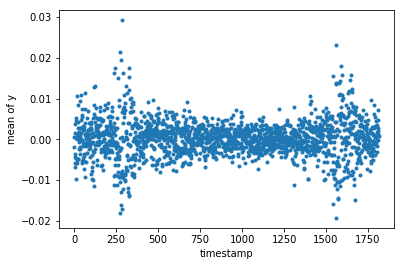

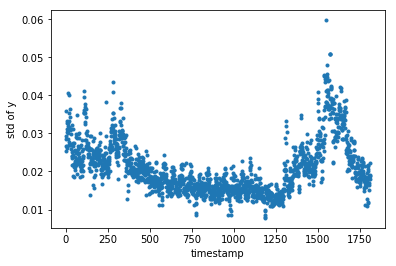

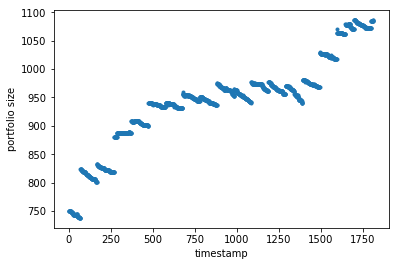

In [29]:
t = market_df['timestamp']
y_mean = np.array(market_df['y']['mean'])
y_std = np.array(market_df['y']['std'])
n = np.array(market_df['y']['len'])

plt.figure()
plt.plot(t, y_mean, '.')
plt.xlabel('timestamp')
plt.ylabel('mean of y')

plt.figure()
plt.plot(t, y_std, '.')
plt.xlabel('timestamp')
plt.ylabel('std of y')

plt.figure()
plt.plot(t, n, '.')
plt.xlabel('timestamp')
plt.ylabel('portfolio size')

Looks like two periods of high variance that are correlated with rapid increases in the number of assets. The number of assets being tracked increases from 750 in the first timestamp to just under 1100 in the last.

The total number of assets across all timestamps is 1424, so some assets are being dropped as well. It looks like assets are added to the portfolio periodically (see the gaps in the chart), and sold off more slowly.

Let's derive a price chart for these returns. We can take the log of the periodic mean returns and get a cumulative sum for each time period to derive a fairly good approximation of a price chart for the portfolio.

portfolio mean periodic return: 0.183126
portfolio std dev of periodic returns: 0.0922067


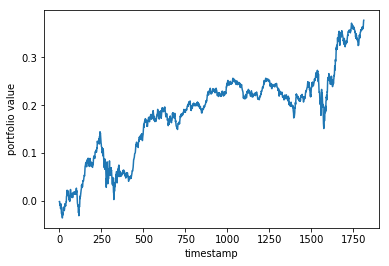

In [30]:
simple_ret = y_mean # this is a vector of the mean of asset returns for each timestamp
cum_ret = np.log(1+simple_ret).cumsum()

portfolio_mean = np.mean(cum_ret)
portfolio_std = np.std(cum_ret)
print("portfolio mean periodic return: " + str(portfolio_mean))
print("portfolio std dev of periodic returns: " + str(portfolio_std))

plt.figure()
plt.plot(t, cum_ret)
plt.xlabel('timestamp')
plt.ylabel('portfolio value')

Taking the log returns and adding them up is a good approximation for the compounding of returns. It would be interesting to see how the returns of individual assets correlate to the portfolio returns (determine alpha and beta for each asset with respect to the portfolio). Maybe we can use the portfolio return as a proxy for the market return.

Recall that the simple regression model for the return of an individual asset, using the market (or index) return as a feature is:   return[asset i] = alpha[asset i] + beta * return[market]

Alpha represents the component of asset returns that cannot be attributed to the market portfolio returns (and may reflect the skill - or luck - of the portfolio manager). Beta represents the asset volatility with respect to the market portfolio. For example, an asset with a beta of 1.5 will rise or fall on average 1.5 times the value of the market portfolio (or index).

Let's take a look at some individual assets.

In [31]:
assets_df = df.groupby('id')['y'].agg(['mean','std',len]).reset_index()
assets_df.head()

,id,mean,std,len
0,0,0.0002,0.0144,1646.0
1,6,0.0002,0.0142,728.0
2,7,0.0005,0.0220,1543.0
3,10,-0.0007,0.0277,116.0
4,11,0.0002,0.0127,1813.0


In [32]:
assets_df = assets_df.sort_values(by='mean')
assets_df.head()

,id,mean,std,len
954,1431,-0.0351,0.0631,27.0
62,93,-0.0328,0.0691,25.0
585,882,-0.0154,0.0296,14.0
1085,1637,-0.0140,0.0577,245.0
742,1118,-0.0118,0.0565,133.0


In [33]:
assets_df.describe()

,id,mean,std,len
count,1424.0000,1.4240e+03,1424.0000,1424.0000
mean,1074.4930,1.8630e-04,0.0224,1201.3735
std,621.6132,1.8845e-03,0.0085,646.3983
min,0.0000,-3.5077e-02,0.0035,2.0000
25%,544.5000,-7.5042e-05,0.0164,571.2500
50%,1066.5000,2.7497e-04,0.0208,1485.0000
75%,1610.2500,6.5709e-04,0.0269,1813.0000
max,2158.0000,1.0827e-02,0.0691,1813.0000


Looks like individual asset returns range from a min of -0.035077 to a high of 0.010827, with a mean return of 0.000186 and a std dev of 0.001884.

Assets have a mean holding period of roughly 1201 periods with a std dev of 646 periods, with a min holding period of 2 and a max of 1813 (all periods).

C:\Users\dcjong\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


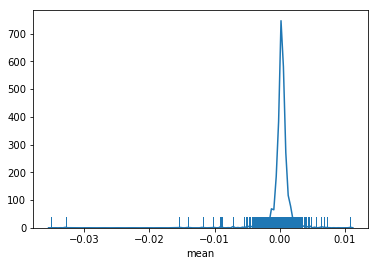

In [34]:
sns.distplot(assets_df['mean'], rug=True, hist=False)

In [35]:
# checking for correlations between asset return, std and holding period
assets_df.corr()

,id,mean,std,len
id,1.0000,0.0157,0.0233,0.0579
mean,0.0157,1.0000,-0.3291,0.0350
std,0.0233,-0.3291,1.0000,-0.2494
len,0.0579,0.0350,-0.2494,1.0000


There seem to be some interesting relationships here. Notably, mean asset returns and holding period are negatively correlated with the std dev of returns.

### 3. Missing Values

Since the training data set (and possibly the test data as well) contain missing data, I wanted to have a closer look at this issue. I have seen that other participants propose to fill those NaNs with the mean or median for the respective column. Here I am not (yet) that much interested in filling the blanks but I rather want to know whether we can learn something more about the data when looking missing values. Let's see which columns have missing values and how much data is actually missing.

<Container object of 111 artists>

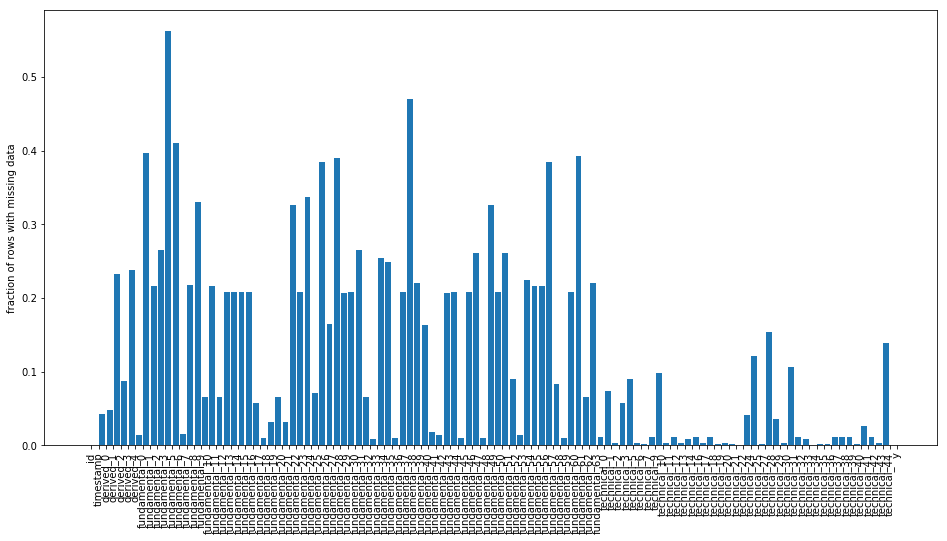

In [36]:
null_counts = df.isnull().sum()/len(df)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

There is quite a lot of missing data. Almost all feature columns contain missing values and the fraction of rows with missing data can be substantial. Ok, let's try to become a bit more quantitative. We can calculate for every ID (= financial asset) and feature column the following information:

- number of missing values
- relative fraction of missing values (= number missing values / timespan for which this ID is present)
- number of continuous time spans with missing values (to see whether data is only missing for a certain period of time or whether missing values occur irregularly over the total time span an asset is held)

In [37]:
# drop non-feature columns or select some feature columns
#feature_columns = df.columns.drop(['id','timestamp','y'])
feature_columns = ['technical_20', 'technical_30']

# create multi-index with (count, fraction, number of NaN sequences) per feature column
iterables = [feature_columns,['count','fraction','seq']]
index = pd.MultiIndex.from_product(iterables, names=['feature','stat'])

# use list of IDs as index (only sorted for easier navigation)
ids = df.id.unique()
ids.sort()

The calculation should be straightforward except maybe for the number of connected time ranges with missing data. Here the idea is the following:

- get the row indices for NaNs in a feature column
- enumerate those indices
- for a continuous time period of NaNs enumeration index - row index should be constant
- use groupby from itertools to get the list of continous time spans of NaNs

In [38]:
# create empty data frame
nan_df = pd.DataFrame(data=None,index=ids,columns=index)

# iterate over all asset ID
for name,group in df.groupby('id'):
    # for every feature column
    for c in feature_columns:
        # total number of rows with missing data
        nan_count = group[c].isnull().sum()
        # time span this ID was present
        timespan = len(group[c])
        # row indices for missing data
        nan_indices = pd.isnull(group[c]).nonzero()[0]
        # get number of joint time spans of missing values
        nseq = len(list(groupby(enumerate(nan_indices),lambda x:x[0]-x[1])))
        nan_df.loc[name][c,'count'] = nan_count
        nan_df.loc[name][c,'fraction'] = nan_count * 1.0/timespan
        nan_df.loc[name][c,'seq'] = nseq
        
nan_df.head()

feature technical_20               technical_30              
stat           count  fraction seq        count  fraction seq
0                  8   0.00486   1            8   0.00486   1
6                  7  0.009615   1            7  0.009615   1
7                  7  0.004537   1            7  0.004537   1
10                 0         0   0            0         0   0
11                 0         0   0            0         0   0

Ok, this looks reasonable at the first glance. In order to get a better feeling, let's have a look at the mean fraction of missing data per feature column and its standard deviation (where mean and std are calculated over the sample of all IDs in the training data).

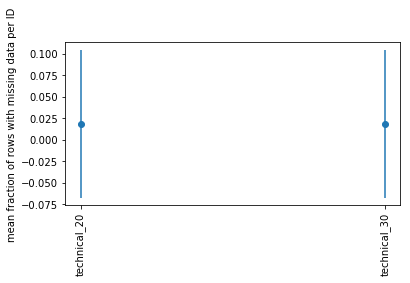

In [39]:
fractions = nan_df.xs('fraction',level='stat',axis=1)
fraction_mean = fractions.mean()
fraction_std = fractions.std()
plt.figure(figsize=(6,3))
plt.xticks(np.arange(len(fraction_mean)),fraction_mean.index,rotation='vertical')
plt.errorbar(np.arange(len(fraction_mean)),fraction_mean,yerr=fraction_std,fmt='o')
plt.ylabel('mean fraction of rows with missing data per ID');

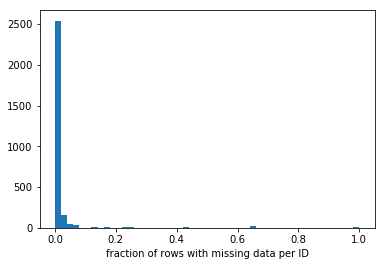

In [40]:
plt.hist(fractions.values.flatten(),bins=50)
plt.xlabel('fraction of rows with missing data per ID');

This looks interesting. For a given ID and feature column either <30% of the data is missing or all of it. The large gap in between renders the mean values a bit misleading. But what it is interesting to me is the fact that the standard deviation varies quite a bit. For fundamental and derived data the variations among different IDs seem to be (in general) larger than for the technical feature columns. One reason could be that fundamental data could be missing for fixed number of time stamps (e.g. the first N occurences) which would lead to large variations since time spans for which different IDs are present vary quite a bit as other participants already revealed. In order to test this, we can make the same plot for the absolute number of missing values per feature column.

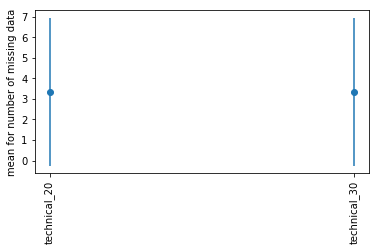

In [41]:
counts = nan_df.xs('count',level='stat',axis=1)
count_mean = counts.mean()
count_std = counts.std()
plt.figure(figsize=(6,3))
plt.xticks(np.arange(len(count_mean)),count_mean.index,rotation='vertical')
plt.errorbar(np.arange(len(count_mean)),count_mean,yerr=count_std,fmt='o')
plt.ylabel('mean for number of missing data')

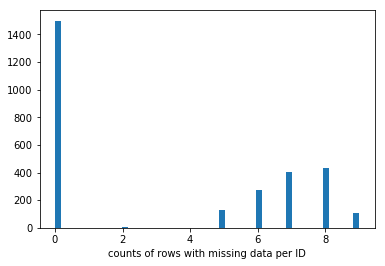

In [42]:
plt.hist(counts.values.flatten(),bins=50)
plt.xlabel('counts of rows with missing data per ID');

Nope, the picture remains the same. My conclusion from this is that there are different classes of IDs which have a different availability of fundamental and derived data. Before pursuing this route further, let's also look at the number of connected time spans for missing data.

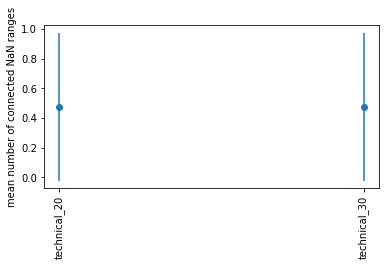

In [43]:
nseq = nan_df.xs('seq',level='stat',axis=1)
nseq_mean = nseq.mean()
nseq_std = nseq.std()
plt.figure(figsize=(6,3))
plt.xticks(np.arange(len(nseq_mean)),nseq_mean.index,rotation='vertical')
plt.errorbar(np.arange(len(nseq_mean)),nseq_mean,yerr=nseq_std,fmt='o')
plt.ylabel('mean number of connected NaN ranges')

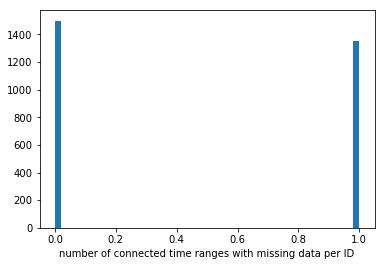

In [44]:
plt.hist(nseq.values.flatten(),bins=50)
plt.xlabel('number of connected time ranges with missing data per ID');

This is very interesting. This means that rows with missing data for a given ID and feature are always continuous in time. It is not the case that data for an asset is unavailable, becomes available and then becomes unavailable again. I bet that if data is unavailable, it is at the beginning of the time interval in which the corresponding asset is traded. Let's try to visualize this.

In [45]:
## iterate over IDs

#grouped = df.groupby('id');
#for i,(n,g) in enumerate(grouped):
#   # get missing data flag for feature columns
#    d = g.isnull().drop(['timestamp','id','y'],axis=1)
#    # normalise time stamp to start with 0 when ID appears for the first time in portfolio
#    d.index = g.timestamp - g.timestamp.min()
#    d.index.name = 'relative timestamp'
#    plt.figure(figsize=(16,12))
#    plt.title("ID = %d" % n)
#    sns.heatmap(d.T,xticklabels=100,cbar=False)
#    # only plot first 10 IDs
#    if i > 3:
#        break

del nan_df

### 4. Corrlations

Technical_20 and technical_30 may be the most useful features in this competition. Hete I will investigate what the physical meanings of these two features.

In [46]:
# fill those NaNs with the 0
corr_df1 = df.copy().fillna(0)

# take technical 20 as an example and run a simple correlation
print(np.corrcoef(corr_df1['technical_20'].values, corr_df1.y.values))

[[ 1.         -0.01641542]
 [-0.01641542  1.        ]]


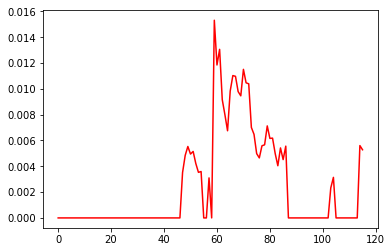

In [47]:
# plot technical 20 for a single asset, say id = 0
X = corr_df1.loc[corr_df1.id == corr_df1.id[0]]['technical_20'].values
Y = corr_df1.loc[corr_df1.id == corr_df1.id[0]]['y'].values
plt.plot(X, color='r')
plt.show()

This does not look stationary. Now lets plot after taking the first differential of technical 20 by asset Id 0.

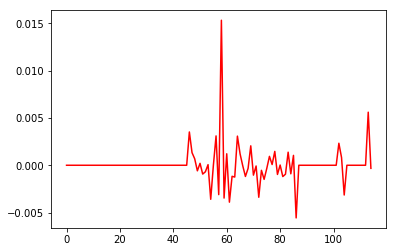

In [48]:
X = np.diff(X)
plt.plot(X, color='r')

Still does not look stationary. Lets difference again.

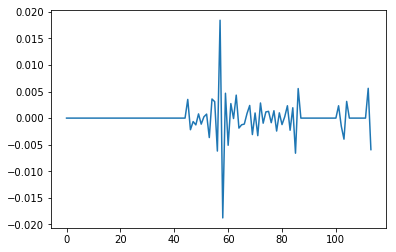

In [49]:
X = np.diff(X)
plt.plot(X)
plt.show()

Now lets compute the correlation between the two times differenced X and Y values.

In [50]:
print(np.corrcoef(X, Y[2:])[0, 1])

-0.1805111759


Correlations on un-differenced data are spurious and make no sense. You have to difference to find stationary series before looking for correlations. Fortunately train.y (appears to be asset returns) are already stationary. Secondly correlations are not same across asset ids. Each asset has a different correlation to features.

Now we choose one random asset id, and plot the technical_20 - y curve. For better visualization, we scale the technical_20 values.

id: 1561


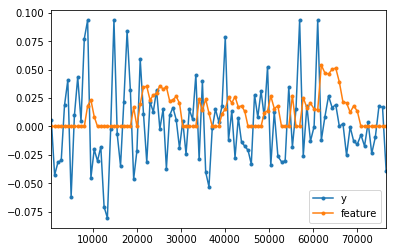

In [51]:
id = 1561 #val_set.id.sample().values[0]
print("id:", id)

temp = corr_df1[corr_df1.id==id]
temp['feature'] = temp['technical_20']
temp['feature'] = temp['feature'] * 4
temp[['y', 'feature']].iloc[:100,:].plot(marker='.')

Y values vibrates strongly. In this figure it is hard for us to find a clear relation between technical_20 and y. We try the cumsum of y values.

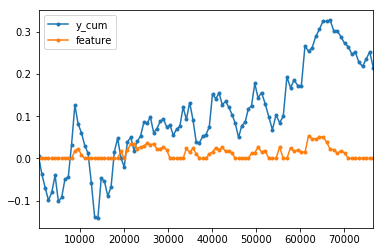

In [52]:
temp['y_cum'] = temp.y.cumsum()
temp[['y_cum', 'feature']].iloc[:100,:].plot(marker='.')

Now we can find something interesting. When the price of the asset increase, technical_20 becomes positive, otherwise technical_20 is zero. Similar relation between technical_30 and cum_sum of y can be found, while it is negative correlation. So we may guess technical_20 may indicate the increase of the price.

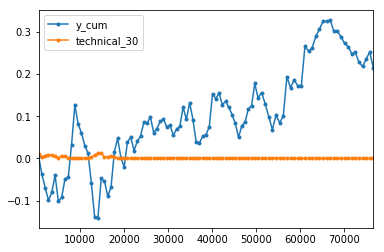

In [53]:
temp[['y_cum', 'technical_30']].iloc[:100,:].plot(marker='.')

We quickly check whether the correlation between techical_20, techical_30 and y is positive as we observed.

In [54]:
print(np.correlate(temp['y'], temp['technical_20']))
print(np.correlate(temp['y'], temp['technical_30']))

[-0.00031707]
[ 0.00022395]


It is weird. The true correlation between y and technical_20 is negative. Follow the [method][method], we quickly implement a linear regression using technical_20.

[method]:https://www.kaggle.com/achalshah/two-sigma-financial-modeling/linear-regression-lb-0-0091176

In [55]:
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * np.sqrt(abs(R2))
    return(R)

In [56]:
corr_df2 = df.copy()

cols = 'technical_20'
low_y_cut = -0.086093
high_y_cut = 0.093497

y_values_within = ((corr_df2['y'] > low_y_cut) & (corr_df2['y'] <high_y_cut))

train_cut = corr_df2.loc[y_values_within,:]

# fill missing values
mean_vals = train_cut.mean()
train_cut.fillna(mean_vals,inplace=True)

x_train = train_cut[cols]
y = train_cut["y"]

lr_model = LinearRegression()
lr_model.fit(np.array(x_train.values).reshape(-1,1),y.values)

val_set = corr_df2[corr_df2.timestamp>=906]
x_val = val_set[cols].fillna(mean_vals[cols])
pred = lr_model.predict(x_val.values.reshape(-1, 1))
re = get_reward(val_set['y'], pred)

print("public score: {}".format(re))
print("learned parameter of the model: {}".format(lr_model.coef_))

public score: 0.017108387542070745
learned parameter of the model: [-0.13519181]


The coefficients is negative. Carefully exam the the technical_20 - y curve, we may find that technical_20 looks like the lag of the y value. To verify this hypothesis, we use t day's technical_20 to predict t-1 day's y.


In [57]:
train_cut = corr_df2.loc[y_values_within,:]
x_train = train_cut.groupby('id')[cols].shift(-1).fillna(mean_vals[cols])
y = train_cut["y"]

lr_model2 = LinearRegression()
lr_model2.fit(np.array(x_train.values).reshape(-1,1),y.values)

x_val = val_set.groupby('id')[cols].shift(-1).fillna(mean_vals[cols])
pred = lr_model2.predict(x_val.values.reshape(-1, 1))
re = get_reward(val_set['y'], pred)

print("public score: {}".format(re))
print("learned parameter of the model: {}".format(lr_model2.coef_))

public score: 0.2598982805810189
learned parameter of the model: [ 1.60653484]


Wow, the public score is 0.26. Such a high score indicate that technical_20 is derived from t-1 day's y value. Since technical_20 relates to the increase while technical_30 relates to the decrease, we construct a new feature technical_20-30 using technical_20 minus technical_30. With the help of Linear Regression, we use previous days' y values estimate this feature and investigate the physical meanings.

Estimator: 0.000143608 , [ 0.06922235  0.06366343  0.05833882  0.05318841  0.04781554]
id: 142


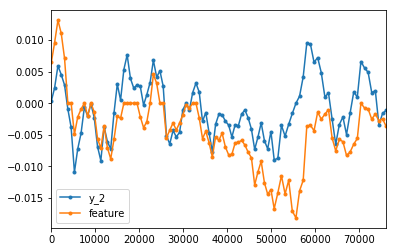

In [58]:
temp = corr_df2.copy()
temp['feature'] = temp['technical_20'] - temp['technical_30']

n = 5
for i in range(1, n+1):
    temp['fea_%d'%i] = temp.groupby('id')['y'].shift(i)
temp = temp.filter(regex='^fea').dropna()

estimator = LinearRegression()
estimator.fit(temp.filter(regex='^fea_').values, temp.feature.values)
print("Estimator:", estimator.intercept_, ",", estimator.coef_)

id = 142 #full_df.id.sample().values[0]
print("id:", id)

temp = corr_df2[corr_df2.id==id]
temp['feature'] = temp['technical_20'] - temp['technical_30']

mean_vals = temp.y.mean()
for i in range(1, n+1):
    temp['fea_%d'%i] = temp['y'].shift(i)
    
temp['y_2'] = estimator.predict(temp.filter(regex='^fea_').fillna(mean_vals).values)
temp[['y_2', 'feature']].iloc[:100,:].plot(marker='.')

The estimated feature roughly looks like the true features. And from the coefficients of estimator, we can guess 20-30 is a kind of moving average the y values. We use more y values to predict feature.

Estimator: 5.77913e-05 , [ 0.06911039  0.06370544  0.05868772  0.05390176  0.0494177   0.04538225
  0.04167278  0.03830548  0.03509734  0.03224528  0.02948501  0.02703383
  0.0248101   0.02254016  0.02038291  0.01871883  0.01710865  0.01583171
  0.01470541  0.01309993]


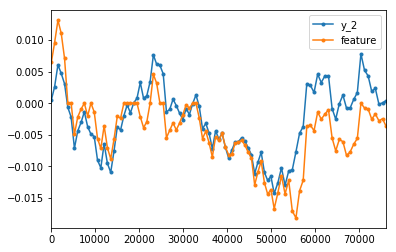

In [59]:
temp = corr_df2.copy()
temp['feature'] = temp['technical_20'] - temp['technical_30']

n = 20
for i in range(1, n+1):
    temp['fea_%d'%i] = temp.groupby('id')['y'].shift(i)
temp = temp.filter(regex='^fea').dropna()

estimator = LinearRegression()
estimator.fit(temp.filter(regex='^fea_').values, temp.feature.values)
print("Estimator:", estimator.intercept_, ",", estimator.coef_)

id = 142 #full_df.id.sample().values[0]
temp = corr_df2[corr_df2.id==id]
temp['feature'] = temp['technical_20'] - temp['technical_30']

mean_vals = temp.y.mean()
for i in range(1, n+1):
    temp['fea_%d'%i] = temp['y'].shift(i)
    
temp['y_2'] = estimator.predict(temp.filter(regex='^fea_').fillna(mean_vals).values)
temp[['y_2', 'feature']].iloc[:100,:].plot(marker='.')

When we use more y values, the estimated feature is more accurate. So we can say technical_20 and technical_30 is a kind of weighted moving mean of historical y values, and nearer y values have larger weights. Now we try to how these weights shrink.

In [60]:
for i in range(len(estimator.coef_)-1):
    print(estimator.coef_[i+1]/estimator.coef_[i])

0.921793
0.921236
0.91845
0.91681
0.91834
0.918262
0.919197
0.916248
0.918739
0.914398
0.916867
0.917743
0.908507
0.904293
0.918359
0.913981
0.925363
0.928858
0.890824


It seems the shrink scale is around 0.92. Denote technical_20-30 as F. So we assume F(t) = 0.07 y(t-1) + 0.92 F(t-1). Have a quick verification.

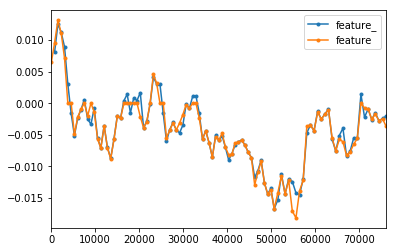

In [61]:
temp['feature_'] = 0.07 * temp['fea_1'] + 0.92 * temp['feature'].shift(1)
temp[['feature_', 'feature']].iloc[:100,:].plot(marker='.')

Bravo! The hypothetical feature curve is very close to the true curve. So we can confirm that the feature comes in this way. However, as we see before, the technical_20, and technical_30 are clipped to a lower bound 0, so in some case, the curve will be not exactly same as we assume, especially when 0 appears frequently. For example:

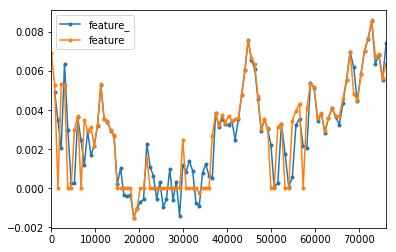

In [62]:
id = 12 #full_df.id.sample().values[0]
temp = corr_df2[corr_df2.id==id]
temp['feature'] = temp['technical_20'] - temp['technical_30']
temp['feature_'] = 0.07 * temp['y'].shift(1) + 0.92 * temp['feature'].shift(1)
temp[['feature_', 'feature']].iloc[:100,:].plot(marker='.')

del corr_df1, corr_df2, temp

###  5. Cluster Securities and Mean Cumulative Returns

There is a large diversity of securities in the dataset. This probably makes building a single model for all id's very difficult. On the other hand, building a model for each of the securities individually is out of reach. Therefore it might be a good idea to seperate the securities into a couple of groups on which we can train a model jointy. 

I will do the clustering soley based on the first four moments of the asset returns (y) as I assume that these contain almost all of the relevant information that characterize different asset types.

I will neglect that certain securities are only available for a subperiod and may therefore have characteristics dominated by the temporary regime. In a further study the temporal component may be included in the clustering process, e.g. recluster every n timestep using the last m observations.

In [63]:
moments = df[['id', 'y']].groupby('id').agg([np.mean, np.std, stats.kurtosis, stats.skew]).reset_index()
moments.head()

id       y                         
         mean     std kurtosis    skew
0   0  0.0002  0.0144   5.1699  0.1320
1   6  0.0002  0.0142   2.9719 -0.0901
2   7  0.0005  0.0220   5.3042  0.4145
3  10 -0.0007  0.0277   2.9894 -0.0080
4  11  0.0002  0.0127   4.9531 -0.0278

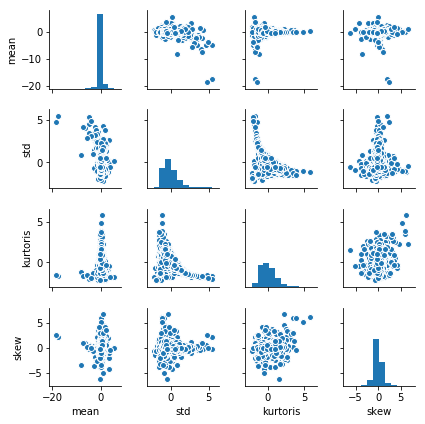

In [64]:
sec = moments['id']
dat = moments['y']

# scale the data
scal = StandardScaler()
dat = scal.fit_transform(dat)

# visualize the data
dat = pd.DataFrame(dat)
dat.columns = ['mean', 'std', 'kurtoris', 'skew']
sns.pairplot(dat, size=1.5);

There are no well seperated clusters visible, but the plots nevertheless promise some kind diversity which we might be able to exploit.

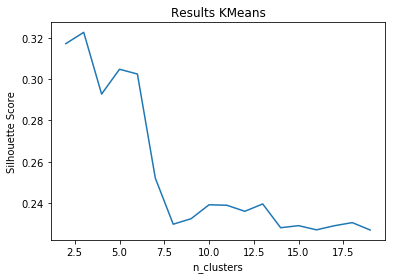

In [65]:
# determine suitable number of clusters with silhouette score
k_max = 20
k_range = range(2,k_max)
scores = []
for k in k_range:
    model = KMeans(n_clusters=k, n_init=20).fit(dat)
    scores.append(silhouette_score(dat, model.labels_))
    
# plotting clusters
plt.figure()
plt.plot(k_range, scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.ylabel('Silhouette Score');

This plot suggests that we should choose a k between 2 and 6. I will continue with a k=3.

In [66]:
k = 3
model = KMeans(n_clusters=k).fit(dat)
labels = pd.DataFrame([sec,model.labels_]).transpose()
labels.columns = ['sec', 'label']
labels.head()

,sec,label
0,0,0
1,6,0
2,7,0
3,10,1
4,11,0


In [67]:
# create list of list such that members[i] contains id's with label i
members = []
for i in range(k):
    members.append(list(labels.sec[labels.label==i]))
print("Size of each group: ", [len(_) for _ in members])

Size of each group:  [744, 669, 11]


The small group is probably made up by the outliers we saw in the previous plot.

If the different clusters would indeed correspond to different asset classes, I would suspect that the available information for the different id's would reflect that, as bonds have different fundamentals as stocks or certain small caps might not report on all fundamentals that large caps do.

In [68]:
prop_nan = pd.DataFrame(index=range(k), columns=df.columns[2:-1])
for i in range(k): #go through labels
    dfi = df.loc[df['id'].isin(members[i]),:]
    n = len(dfi)
    for col in dfi.columns[2:-1]: #go through feature cols
        prop_nan.set_value(i, col, dfi[col].isnull().sum() / n)
for col in df.columns[2:-1]: #go through feature cols
    prop_nan.set_value('mean', col, df[col].isnull().sum() / len(df))
    
# only look at the features with significant missing data (>10%)
prop_nan_sel = prop_nan.loc[:,prop_nan.loc['mean',:] > 0.1].reset_index()

prop_nan_sel

,index,derived_2,derived_4,fundamental_1,fundamental_2,fundamental_3,fundamental_5,fundamental_6,fundamental_8,fundamental_9,fundamental_11,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_22,fundamental_23,fundamental_24,fundamental_26,fundamental_27,fundamental_28,fundamental_29,fundamental_30,fundamental_31,fundamental_34,fundamental_35,fundamental_37,fundamental_38,fundamental_39,fundamental_40,fundamental_43,fundamental_44,fundamental_46,fundamental_47,fundamental_49,fundamental_50,fundamental_51,fundamental_54,fundamental_55,fundamental_56,fundamental_57,fundamental_60,fundamental_61,fundamental_63,technical_25,technical_28,technical_31,technical_44
0,0,0.2907,0.2853,0.2265,0.2835,0.2928,0.6123,0.2363,0.287,0.3417,0.2835,0.2751,0.2755,0.2751,0.2751,0.3677,0.2756,0.3491,0.2172,0.0608,0.3752,0.2751,0.2751,0.2928,0.3125,0.2901,0.2755,0.2932,0.284,0.1099,0.2755,0.2751,0.2755,0.2811,0.3677,0.2751,0.3208,0.2819,0.2835,0.2835,0.2172,0.2761,0.2214,0.1041,0.1042,0.1327,0.09139,0.1192
1,1,0.1408,0.1606,0.6667,0.1074,0.2211,0.4829,0.6853,0.1076,0.3123,0.1074,0.09984,0.1007,0.09948,0.09984,0.2604,0.1015,0.3174,0.6484,0.3275,0.4126,0.09828,0.09949,0.2211,0.1613,0.1807,0.1004,0.7492,0.1197,0.2481,0.09828,0.1009,0.1004,0.2274,0.2602,0.09998,0.1665,0.1328,0.1074,0.1074,0.6484,0.09828,0.6638,0.4015,0.148,0.1856,0.1301,0.1675
2,2,0.5272,0.7965,0.8838,0.3962,0.8771,0.593,0.8838,0.6817,0.5917,0.3962,0.3962,0.3962,0.3962,0.3962,0.5803,0.3969,0.5917,0.8838,0.8838,0.8838,0.3962,0.3962,0.8771,0.3962,0.5749,0.3962,0.8838,0.3962,0.403,0.3962,0.3962,0.3962,0.8771,0.5803,0.3962,0.3962,0.5272,0.3962,0.3962,0.8838,0.3962,0.8838,0.8838,0.681,0.8032,0.6165,0.7542
3,mean,0.233,0.2376,0.3969,0.2156,0.2656,0.5623,0.4101,0.2181,0.3306,0.2156,0.2076,0.2081,0.2075,0.2076,0.3265,0.2085,0.3371,0.3841,0.1644,0.3901,0.207,0.2075,0.2656,0.2542,0.2481,0.208,0.4697,0.2207,0.1635,0.2072,0.208,0.208,0.2609,0.3264,0.2076,0.2613,0.2246,0.2156,0.2156,0.3841,0.2076,0.3927,0.2196,0.1216,0.1537,0.1068,0.1384


C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\dcj

C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\dcj

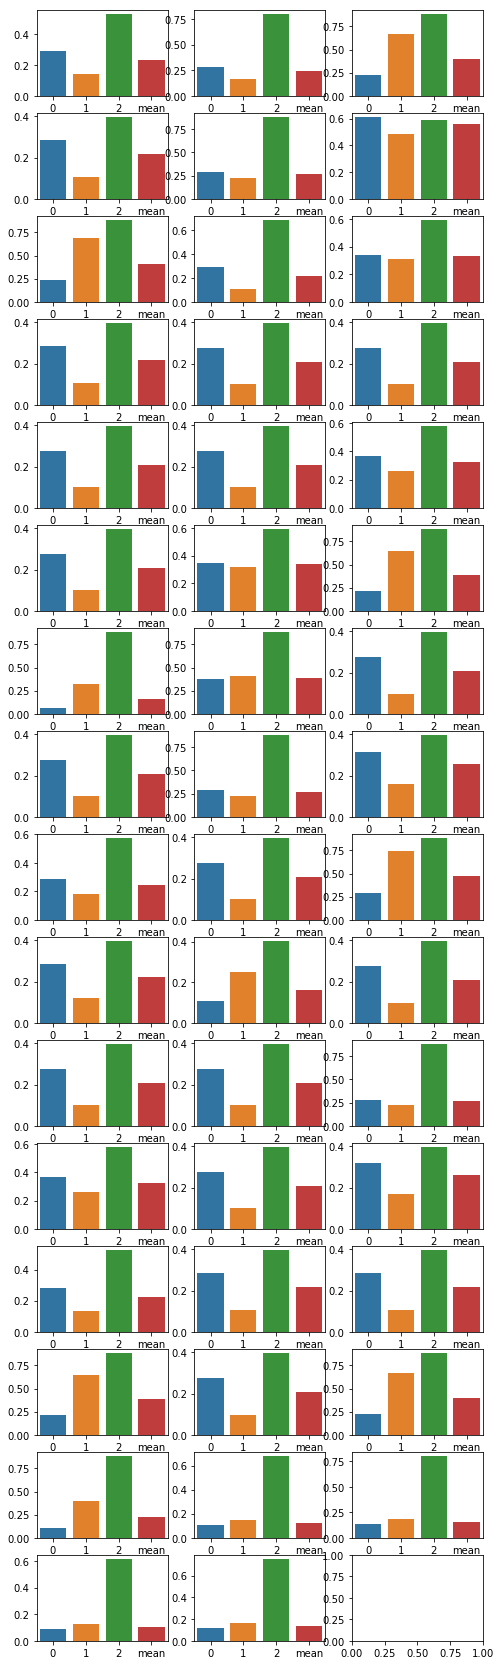

In [69]:
n = len(prop_nan_sel.columns[1:])
cols = 3
f, axarr = plt.subplots(int(n/cols)+1, cols, figsize=(8,30))

i = 0
for col in prop_nan_sel.columns[1:]:
    sns.barplot(x='index', y=col, data=prop_nan_sel,ax=axarr[int(i/cols),i%cols]);
    axarr[int(i/cols),i%cols].set_ylabel('')
    axarr[int(i/cols),i%cols].set_xlabel('')
    i += 1
    
del moments, prop_nan

Apparently our 'outlier class' has a significant amount of missing data. A reasonable explanation would be that these securities are penny stocks or the like which are highly volatile and don't have to publish the same data as blue chips do. We can also observe that there are features for which either one of the two main classes, 0 or 1, have significantly more missing data than the other one. Maybe just confirmation bias (?) but is probably still worth digging deeper...

Now let's assume we have lots of randomly generated curves (e.g. cumulative return) and we look at their correlations. Then we might find a subset of curves that are highly correlated and go up and about the same number of curves that are highly correlated and go down. The end result might look like what we got here. To see if the findings are for real the clustering is now performed up to the timestamp 900, ignoring everything that happens after that. The result is presented for all timestamps up to 1812. The new interpretation: There are probably no clusters with respect to the cumulative returns (at least not with the methodology used here) as the upward and downward trend of the clusters suddenly levels of after the timestamp 900 (in the old analysis these trends continued).

We will calculate correlations between all the id's but to ensure that we have enough overlap we only look at those id's that have more than 450 timestamps (i.e. at least 50% of data available). Additionally, we will later only keep id's that are generally highly correlated with other id's. That's what the parameter N_corr_cut is good for.

In [70]:
# data is used for clustering --> see comment at the beginning
cluster_df = df.copy()
cluster_df = cluster_df.iloc[0:450000,:]

# params
N_timestamps = 450 # how many timestamps that are non-nan for each id
N_corr_cut = 0.4 # min mean correlation coefficient when dropping id's

# check max timestamp
print('max timestamp:', np.max(cluster_df.timestamp))

# select only id's where sufficient data is available, i.e. all timestamps available
select_ids = cluster_df[["id","y"]].groupby("id").count()
selected_ids = select_ids[select_ids.y > N_timestamps] #== N_timestamps
selected_ids = np.array(selected_ids.index)
index_ids = [i in selected_ids for i in cluster_df.id]
data_corr = cluster_df[index_ids][["id","timestamp","y"]]

max timestamp: 528


In [71]:
# create a dataframe where each id is a column
df_id = data_corr[['id', 'timestamp', 'y']].pivot_table(values='y',index='timestamp',columns='id')

# calculate the cumulative sum of the return y and substract the mean of the cumulative sum at each timestamp
df_id_cumsum = df_id.cumsum()
diff = df_id_cumsum.mean(axis=1)
df_id_cumsum = df_id_cumsum.subtract(diff.values,axis="rows")

print(df_id_cumsum.shape)
df_id_cumsum.head()

(529, 771)


id,11,12,16,25,26,31,38,39,40,41,43,44,48,49,54,59,60,66,68,69,70,76,79,80,82,83,85,87,90,95,98,100,112,113,118,119,121,124,126,128,129,130,132,140,141,142,152,154,156,160,171,172,175,176,178,184,186,187,191,195,...,2018,2021,2027,2030,2033,2035,2036,2037,2043,2044,2045,2047,2050,2054,2055,2056,2057,2059,2062,2064,2065,2066,2069,2070,2074,2078,2079,2080,2082,2083,2088,2089,2092,2095,2100,2101,2102,2104,2108,2109,2112,2114,2120,2124,2125,2126,2129,2130,2131,2134,2136,2138,2142,2146,2148,2149,2151,2154,2155,2156
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0005,-0.0192,NaN,-0.0142,-0.0056,-0.0311,0.0176,-0.0258,0.0084,-1.1678e-04,0.0520,-0.0172,NaN,-0.0034,-0.0046,0.0196,0.0007,NaN,-0.0021,-9.5344e-03,0.0459,0.0032,-0.0103,-0.0691,1.6337e-05,-0.0108,0.0315,0.0326,-0.0146,-0.0180,-0.0173,NaN,-0.0005,-0.0102,-0.0397,0.0180,-0.0182,-0.0021,-0.0231,-0.0114,0.0686,-0.0003,0.0022,-0.0218,0.0050,0.0331,-0.0015,0.0004,-0.0072,-0.0108,0.0032,-0.0077,-0.0537,0.0015,-0.0323,0.0353,-0.0077,0.0156,-0.0046,-0.0111,...,-0.0068,0.0622,-0.0843,0.0097,-0.0030,NaN,-0.0118,-0.0012,-0.0500,-0.0021,NaN,0.0196,0.0050,-0.0823,-0.0004,-0.0110,-0.0064,-0.0324,0.0255,NaN,0.0020,-0.0243,-0.0133,0.0260,0.0069,0.0106,0.0249,0.0053,NaN,-0.0076,NaN,0.0391,-0.0012,0.0247,0.0046,0.0234,NaN,0.0073,-0.0106,0.0130,-0.0037,0.0484,NaN,-0.0062,-0.0638,-0.0120,-0.0146,NaN,0.0125,-0.0004,-0.0076,0.0138,0.0039,0.0550,-0.0132,-0.0146,NaN,-0.0144,NaN,-0.0099
1,-0.0022,-0.0400,NaN,-0.0194,-0.0173,-0.0273,0.0201,-0.0599,0.0030,2.8947e-03,0.0462,-0.0033,NaN,0.0202,0.0365,0.0042,-0.0409,NaN,0.0621,-1.1600e-02,0.0765,0.0119,0.0320,-0.0527,1.2614e-02,0.0039,0.0404,0.1188,-0.0112,-0.0389,-0.0438,NaN,-0.0336,-0.0187,0.0182,0.0074,-0.0044,-0.0069,-0.0419,-0.0230,0.0639,-0.0124,-0.0358,-0.0187,0.0143,0.0854,0.0371,-0.0193,0.0002,-0.0096,-0.0290,-0.0490,-0.0469,0.0530,-0.0383,0.0636,-0.0061,-0.0003,-0.0051,-0.0443,...,-0.0132,-0.0024,-0.0524,0.0369,-0.0026,NaN,-0.0234,0.0151,0.0204,-0.0513,NaN,0.0093,0.0163,-0.1314,-0.0081,-0.0149,-0.0171,-0.0823,-0.0115,NaN,-0.0012,-0.0005,-0.0010,-0.0048,0.0107,0.0082,0.0237,-0.0208,NaN,0.0196,NaN,0.0415,0.0150,0.0072,-0.0188,0.0671,NaN,0.0040,-0.0156,-0.0039,-0.0034,0.0832,NaN,-0.0003,-0.0457,-0.0270,-0.0082,NaN,0.0372,-0.0399,-0.0129,-0.0142,0.0114,0.0399,-0.0087,-0.0603,NaN,0.0138,NaN,-0.0027
2,0.0121,-0.0052,NaN,-0.0160,-0.0027,-0.0296,0.0358,-0.0363,0.0075,-7.0798e-03,0.0359,0.0180,NaN,-0.0240,0.0578,0.0070,-0.0746,NaN,-0.0184,-1.1940e-02,0.1032,0.0325,-0.0219,-0.0867,1.8166e-02,0.0126,0.0695,0.0432,0.0069,-0.0139,-0.0362,NaN,-0.0272,-0.0017,-0.0119,-0.0178,0.0087,0.0012,-0.0224,-0.0251,0.0679,-0.0150,-0.0945,-0.0368,0.0461,0.0783,0.0476,-0.0046,-0.0046,0.0252,-0.0113,-0.0198,-0.0676,0.0571,-0.0585,0.0686,-0.0126,-0.0537,-0.0006,-0.0250,...,-0.0170,-0.0206,-0.1330,0.0990,0.0410,NaN,-0.0330,0.0543,-0.0104,-0.0961,NaN,0.0368,-0.0342,-0.1811,-0.0017,0.0028,-0.0055,-0.1272,-0.0301,NaN,0.0035,0.0022,0.0113,-0.0854,0.0347,0.0204,0.0059,-0.0261,NaN,0.0610,NaN,0.0378,0.0246,0.0239,0.0003,0.0889,NaN,0.0076,0.0083,0.0276,-0.0035,0.0983,NaN,0.0027,-0.1150,-0.0292,-0.0077,NaN,0.0439,-0.0465,-0.0618,0.0083,0.0194,0.0132,0.0328,-0.0592,NaN,0.0177,NaN,0.0011
3,0.0044,0.0150,NaN,-0.0228,-0.0042,-0.0231,0.0256,-0.0173,0.0085,-1.6588e-05,0.0577,0.0328,NaN,-0.0498,0.0634,0.0091,-0.0775,NaN,-0.0724,-3.6726e-05,0.1016,0.0337,-0.0778,-0.0643,3.1154e-02,0.0250,0.0899,-0.0425,0.0138,-0.0260,-0.0311,NaN,-0.0101,0.0006,-0.0364,-0.0372,0.0034,0.0110,-0.0454,-0.0438,0.0571,-0.0073,-0.1256,-0.0169,0.0638,0.0591,0.0318,0.0105,-0.0019,0.0308,0.0158,-0.0396,-0.1042,0.0593,-0.0652,0.0820,-0.0020,-0.0843,0.0066,-0.0230,...,0.0126,0.0020,-0.1811,0.0773,0.0582,NaN,-0.0307,0.0754,-0.0581,-0.1468,NaN,0.0648,-0.0669,-0.2237,0.0059,0.0137,0.0005,-0.1361,-0.0171,NaN,0.0121,0.0027,0.0141,-0.1048,0.0460,0.0432,-0.0145,-0.0742,NaN,0.0716,NaN,-0.0034,0.0396,0.0017,0.0336,0.0926,NaN,0.0292,0.0121,0.0

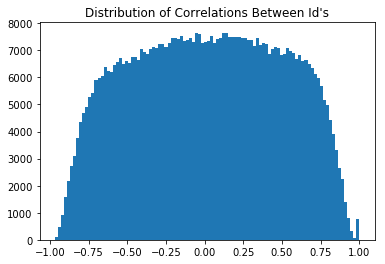

In [72]:
# calculate the correlations between the id's
corr_cumsum = df_id_cumsum.corr()
dist = corr_cumsum.as_matrix()

plt.hist(dist.flatten(),bins=100)
plt.title("Distribution of Correlations Between Id's");

The bimodal distribution vanished after changing the analysis (see comment at beginning of notebook).

Number of id's 445


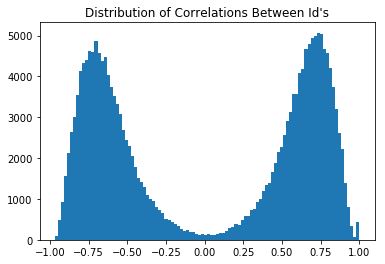

In [73]:
# look at id's that are generally strongly correlated to others

dist_id_mean = np.mean(np.abs(dist),axis = 1)
index_mean = dist_id_mean > N_corr_cut

tmp_cut = dist[index_mean,:]
tmp_cut = tmp_cut[:,index_mean]

print("Number of id's %i" % (tmp_cut.shape[0]))

plt.hist(tmp_cut.flatten(),bins=100)
plt.title("Distribution of Correlations Between Id's");

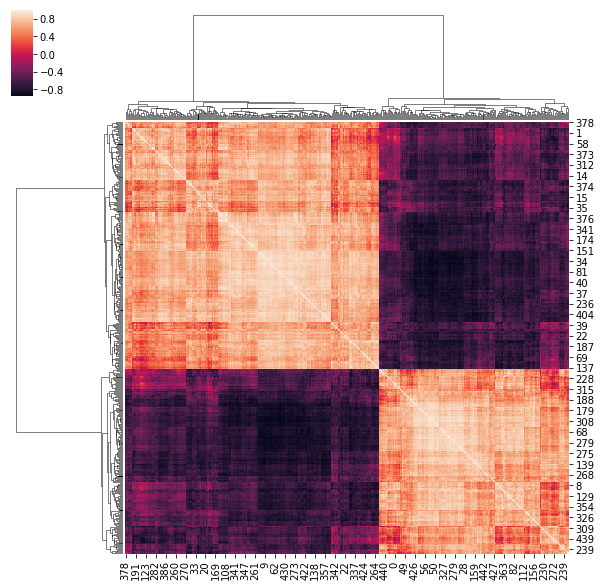

In [74]:
# if the id's form any clusters
g = sns.clustermap(tmp_cut,metric="euclidean",method="average")

Indeed, there are two clusters. Within each cluster the correlations are high and positive. In between clusters these correlations are inverted. Next, we extract these clusters and analyze them.

In [75]:
# perform kmeans to easily get the two clusters
clf = KMeans(n_clusters = 2)
clf.fit(tmp_cut)
labels = clf.labels_
print("%i id's in cluster 1 and %i id's in cluster 2" % (np.sum(labels == 0),np.sum(labels == 1)))

190 id's in cluster 1 and 255 id's in cluster 2


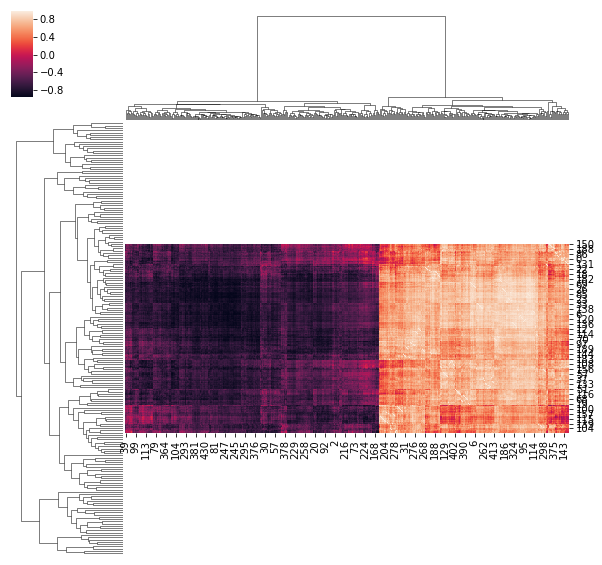

In [76]:
# check to see if kmeans got the clusters right
g = sns.clustermap(tmp_cut[labels == 0,:],metric="euclidean",method="average",square=True)

Looks good. Finally, we will look at the mean cumulative returns for each cluster and compare them. Note that we have already subtracted the general upward trend of the cumulative returns. For comparison, we include the result without that adjustment.

In [77]:
# define one dataframe for each cluster
ids = corr_cumsum.columns[index_mean]

ids_1 = ids[labels == 0]
ids_2 = ids[labels == 1]

data_sub_c1 = df_id_cumsum[ids_1]
data_sub_c2 = df_id_cumsum[ids_2]

# cumulative Sums Without Adjustments

df_id_cumsum_no_adjust = df_id.cumsum()

data_sub_c1_no_adjust = df_id_cumsum_no_adjust[ids_1]
data_sub_c2_no_adjust = df_id_cumsum_no_adjust[ids_2]

Now lets determine mean of cumulative returns.

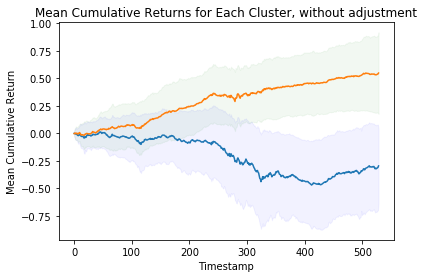

In [78]:
# without adjustment

returns_1 = data_sub_c1_no_adjust.mean(axis=1)
returns_2 = data_sub_c2_no_adjust.mean(axis=1)

std_1 = data_sub_c1_no_adjust.std(axis=1)
std_2 = data_sub_c2_no_adjust.std(axis=1)

plt.plot(returns_1,alpha=1)
plt.plot(returns_2,alpha=1)
plt.title("Mean Cumulative Returns for Each Cluster, without adjustment")
plt.xlabel("Timestamp")
plt.ylabel("Mean Cumulative Return");

plt.fill_between(returns_1.index, returns_1 - std_1, returns_1 + std_1, color='b', alpha=0.05)
plt.fill_between(returns_2.index, returns_2 - std_2, returns_2 + std_2, color='g', alpha=0.05)

plt.show()

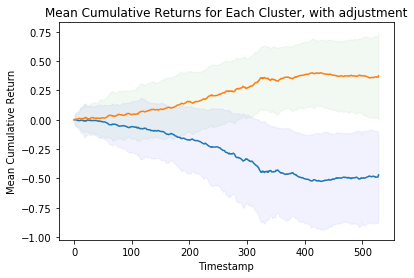

In [79]:
# with adjustment

returns_1 = data_sub_c1.mean(axis=1)
returns_2 = data_sub_c2.mean(axis=1)

std_1 = data_sub_c1.std(axis=1)
std_2 = data_sub_c2.std(axis=1)

plt.plot(returns_1,alpha=1)
plt.plot(returns_2,alpha=1)
plt.title("Mean Cumulative Returns for Each Cluster, with adjustment")
plt.xlabel("Timestamp")
plt.ylabel("Mean Cumulative Return");

plt.fill_between(returns_1.index, returns_1 - std_1, returns_1 + std_1, color='b', alpha=0.05)
plt.fill_between(returns_2.index, returns_2 - std_2, returns_2 + std_2, color='g', alpha=0.05);

del cluster_df

As mentioned in the beginning the clustering is now only performed up to the timestamp 900. This changed the end result quite a bit. Now we can see that the mean cumulative return levels of after 900 and the standard deviation starts to increase. This should be expected for curves that behave in a random way. The fact that they mirror each other closely is probably due to adjusting for the general upward trend in the cumulative mean.

The two curves show the mean cumulative return within each cluster over time. The shaded regions show the standard deviation of the cumulative return within each cluster.

### 6. When/Why are Stocks Bought and Sold

In [80]:
dfId = df[['id', 'timestamp', 'y']].groupby('id').agg([
                    np.min, np.max, len, 
                    lambda m: (list(m)[0] - list(m)[-1])/np.abs(np.mean(list(m))) ]  ).reset_index()
dfId.sort_values([('timestamp', 'amax')], inplace=True, ascending=False)

print(dfId.head())
print(dfId['y'].columns)

       id timestamp                            y                            
               amin  amax   len <lambda>    amin    amax     len    <lambda>
0       0       167  1812  1646  -1.6625 -0.0861  0.0935  1646.0    -27.1370
891  1334         0  1812  1813  -2.0000 -0.0861  0.0935  1813.0    -11.1791
902  1352         0  1812  1813  -2.0000 -0.0861  0.0935  1813.0    -51.8851
901  1350         0  1812  1813  -2.0000 -0.0861  0.0935  1813.0  12468.8057
900  1349      1290  1812   523  -0.3366 -0.0861  0.0935   523.0    -25.4085
Index(['amin', 'amax', 'len', '<lambda>'], dtype='object')


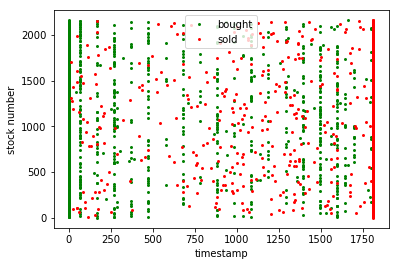

In [81]:
plt.plot(dfId[('timestamp', 'amin')], dfId['id'], '.', mfc='green', mec='None', label='bought')
plt.plot(dfId[('timestamp', 'amax')], dfId['id'], '.', mfc='red',   mec='None', label='sold')
plt.xlabel('timestamp')
plt.ylabel('stock number')
plt.legend()

Why are stocks sold at random points? Is it because the stock prices drop significantly? Let's look at the difference in the price between the start and end of a stock value when they are dropped. Are there any temporal trends in the data?

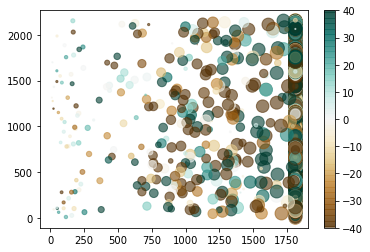

In [82]:
plt.scatter( dfId[('timestamp', 'amax')], 
             dfId['id'], 
             c    = dfId[('y', '<lambda>')], 
             s    = dfId[('timestamp', 'len')]/10,
             cmap = plt.cm.BrBG, vmin=-40, vmax=40).set_alpha(0.6)
plt.colorbar()

It does not appear as if the number to stocks that are sold is is due to the value of the stock taking a dive.

        id       y                                
            median     std    amin    amax    mean
62      93 -0.0861  0.0691 -0.0861  0.0935 -0.0328
954   1431 -0.0572  0.0631 -0.0861  0.0935 -0.0351
742   1118 -0.0222  0.0565 -0.0861  0.0935 -0.0118
1085  1637 -0.0210  0.0577 -0.0861  0.0935 -0.0140
849   1276 -0.0210  0.0685 -0.0861  0.0935 -0.0090
median   -0.0002
std       0.0208
amin     -0.0861
amax      0.0935
mean      0.0003
dtype: float64


C:\Users\dcjong\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\dcjong\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\dcjong\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\dcjong\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\dcjong\Anaconda3\lib\site-packages\

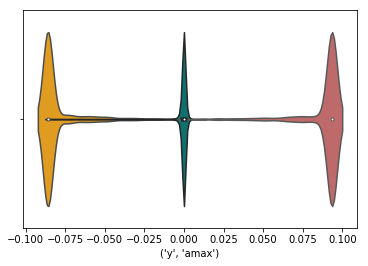

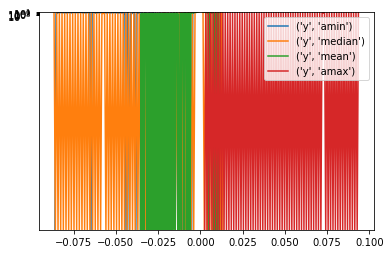

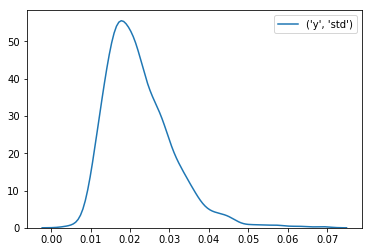

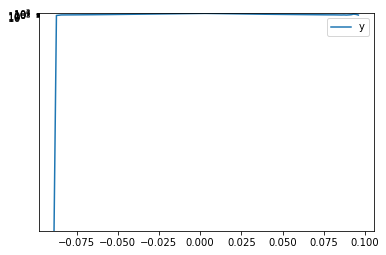

In [83]:
dfStats = df[['y', 'id']].groupby('id').agg([np.median, np.std, np.min, np.max, np.mean]).reset_index()
dfStats.sort_values( ('y', 'median'), inplace=True )
print( dfStats.head() )
print( dfStats['y'].apply(np.median) )

sns.violinplot( dfStats[('y',  'amin')]   , color='orange')
sns.violinplot( dfStats[('y',  'median')] , color='teal')
sns.violinplot( dfStats[('y',  'amax')]   , color='indianred')

plt.figure()
temp = sns.kdeplot(dfStats[('y', 'amin')]  )
temp = sns.kdeplot(dfStats[('y', 'median')])
temp = sns.kdeplot(dfStats[('y', 'mean')]  )
temp = sns.kdeplot(dfStats[('y', 'amax')]  )
plt.yscale('log')

plt.figure()
temp = sns.kdeplot(dfStats[('y', 'std')])

plt.figure()
temp = sns.kdeplot(df['y'])
plt.yscale('log')

Finding distributions of the result.  This is an entire portfolio. It will  be good to see how each variable changes  independent of each other.

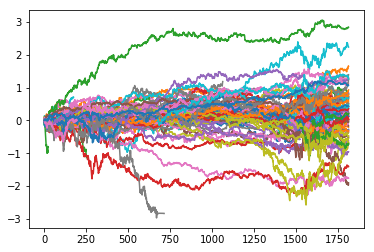

In [84]:
for i, (idVal, dfG) in enumerate(df[['id', 'timestamp', 'y']].groupby('id')):
    if i> 100: break
    df1 = dfG[['timestamp', 'y']].groupby('timestamp').agg(np.mean).reset_index()
    plt.plot(df1['timestamp'], np.cumsum(df1['y']),label='%d'%idVal)

Finding distributions of the result.  This is an entire portfolio. It will  be good to see how each variable changes  independent of each other.

In [85]:
for i, (idVal, dfG) in enumerate(df[['id', 'timestamp', 'y']].groupby('id')):
    if i> 100: break
    #df1 = dfG[['timestamp', 'y']].groupby('timestamp').agg(np.mean).reset_index()
    #plt.plot(df1['timestamp'], np.cumsum(df1['y']),label='%d'%idVal)
    dfG.head()

So this 'asset' is made up of other different assets. Looks like there are several assets that "track each other." One thing to do would be to try and understand which one's do and which one's don't ...

In [86]:
dfStock = df[['id', 'timestamp', 'y']].pivot_table(values='y', index='timestamp', columns='id')

cols = [ c for c in dfStock.columns if str(c) != 'timestamp']
lags = [1]
aCorrs = []
for i, c in enumerate(cols):
    try:
        aCorrs.append((c , max([(dfStock[c].autocorr(lag)) for lag in lags])))
    except:
        pass
    
aCorrs = pd.DataFrame(aCorrs, columns=['id', 'maxAcorr']).sort_values('maxAcorr', ascending=False)
print(aCorrs.head())

       id  maxAcorr
357   546    0.6458
496   752    0.5777
648   980    0.4948
569   861    0.3974
880  1320    0.3635


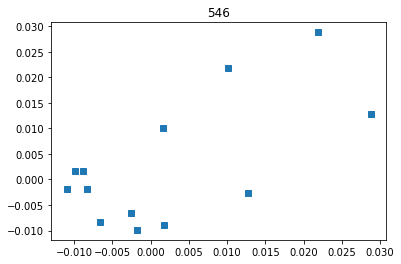

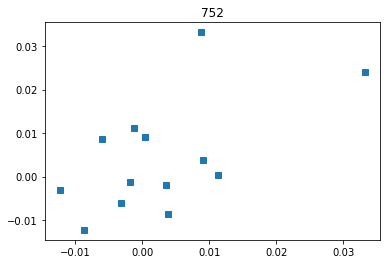

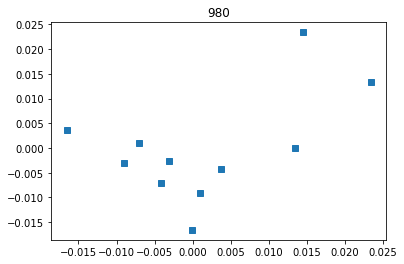

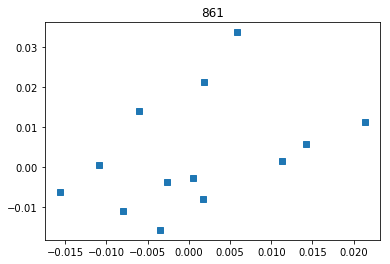

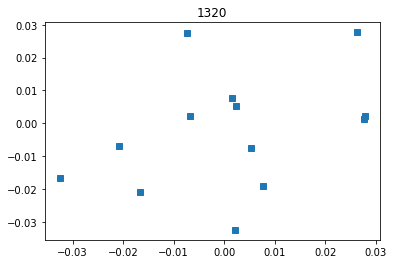

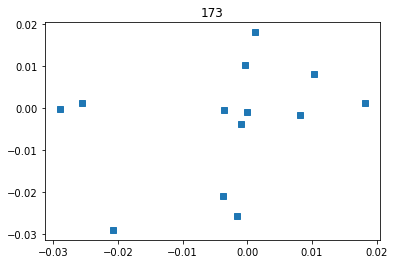

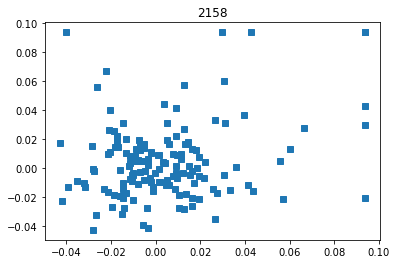

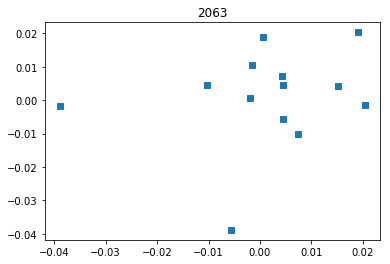

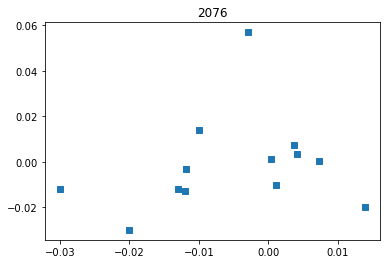

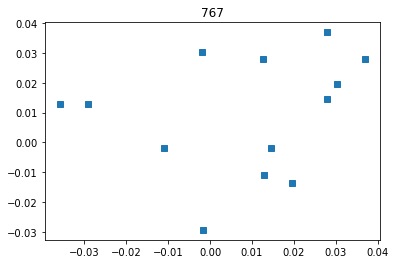

In [87]:
# lets now plot the ones that have the highest autocorrelations
lags = range(1, 15)
for c in list(aCorrs.id)[:10]:
    plt.figure()
    plt.plot(list(dfStock[c])[:-1], list(dfStock[c])[1:], 's')
    plt.title(str(c))
    
cols = [ c for c in dfStock.columns if str(c) != 'timestamp']
corrs = dfStock[cols].corr()

temp = np.where(np.triu(corrs) < -0.9)
temp = [sorted(a) for a in zip(temp[0], temp[1]) if a[0]!=a[1]]

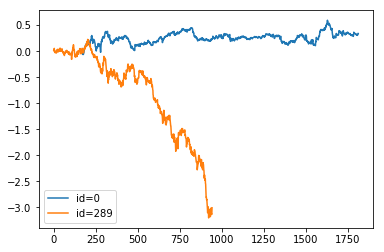

In [88]:
# lets plot the first one that are highly correlated
prevId = -1
for i, (a, b) in enumerate(temp):
    
    if a != prevId:
        plt.figure()
        prevId = a
        plt.plot(np.cumsum(dfStock.loc[:, a]), label='id=%d'%a)
    plt.plot(np.cumsum(dfStock.loc[:, b]), label='id=%d'%b)
    plt.legend()
    
    break
    #if i > 5: break
    
del dfId, dfStats, dfStock

It appears that the portfolio is maintained by some form of advanced "pairs trading" platform. We are supposed to be predicting the result of the result of the entire system.

Because of the "hedging strategy" that it is applying, I believe that the cumsum of the y variable over time is so fairly constant. If we can figure out that, we should be able to do something interesting.

## Model Building

### 1. XGBoost

In [89]:
t0 = time.time()

excl = ['id', 'sample', 'y', 'timestamp']
col = [c for c in df.columns if c not in excl]

df_train = df[df.timestamp <= 905][col]
d_mean= df_train.median(axis=0)

df_all = df[col]
X_train = df_all[df.timestamp <= 905].values
y_train = df.y[df.timestamp <= 905].values
X_valid = df_all[df.timestamp > 905].values
y_valid = df.y[df.timestamp > 905].values
feature_names = df_all.columns

print("Done: %.1fs" % (time.time() - t0))

del df_all, df_train, df

Done: 2.9s


In [90]:
xgmat_train = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
xgmat_valid = xgb.DMatrix(X_valid, label=y_valid, feature_names=feature_names)

params_xgb = {'objective':'reg:linear',
              'eta'             : 0.1,
              'max_depth'       : 4,
              'subsample'       : 0.9,
              #'colsample_bytree':0.8,
              'min_child_weight': 1000,
              'base_score':0}

print ("Training")
t0 = time.time()
bst = xgb.train(params_xgb, xgmat_train, 10)
print("Done: %.1fs" % (time.time() - t0))

Training
Done: 98.5s


In [91]:
params_xgb.update({'process_type': 'update',
                   'updater'     : 'refresh',
                   'refresh_leaf': False})

t0 = time.time()
print("Refreshing")
bst_after = xgb.train(params_xgb, xgmat_valid, 10, xgb_model=bst)
print("Done: %.1fs" % (time.time() - t0))

Refreshing
Done: 7.6s


In [92]:
# before refresh
for line in bst.get_dump(with_stats=True)[0].splitlines()[:10]:
    print(line)

0:[technical_20<0.0121271] yes=1,no=2,missing=2,gain=0.0786013,cover=725241
	1:[technical_30<0.00888576] yes=3,no=4,missing=4,gain=0.0735007,cover=715376
		3:[fundamental_11<0.206276] yes=7,no=8,missing=7,gain=0.0406312,cover=697448
			7:[technical_0<1e-06] yes=13,no=14,missing=14,gain=0.0339804,cover=617966
				13:leaf=1.62736e-05,cover=607084
				14:leaf=-0.000162005,cover=10882
			8:[technical_30<0.00221287] yes=15,no=16,missing=16,gain=0.013206,cover=79482
				15:leaf=7.12018e-05,cover=66648
				16:leaf=0.000181977,cover=12834
		4:[fundamental_51<-0.0187248] yes=9,no=10,missing=9,gain=0.0548799,cover=17928


In [93]:
# after refresh
for line in bst_after.get_dump(with_stats=True)[0].splitlines()[:10]:
    print(line)

0:[technical_20<0.0121271] yes=1,no=2,missing=2,gain=0.101079,cover=904458
	1:[technical_30<0.00888576] yes=3,no=4,missing=4,gain=0.0424804,cover=889691
		3:[fundamental_11<0.206276] yes=7,no=8,missing=7,gain=0.0315255,cover=866646
			7:[technical_0<1e-06] yes=13,no=14,missing=14,gain=-0.000129486,cover=706313
				13:leaf=1.62736e-05,cover=706001
				14:leaf=-0.000162005,cover=312
			8:[technical_30<0.00221287] yes=15,no=16,missing=16,gain=4.65078e-05,cover=160333
				15:leaf=7.12018e-05,cover=127263
				16:leaf=0.000181977,cover=33070
		4:[fundamental_51<-0.0187248] yes=9,no=10,missing=9,gain=0.00859293,cover=23045


It only updated gain and cover values. The leaf values remain fixed.

### 2. Feature Importances

In [94]:
imp = pd.DataFrame(index=feature_names)
imp['train'] = pd.Series(bst.get_score(importance_type='gain'), index=feature_names)

# OOB feature importance
imp['OOB'] = pd.Series(bst_after.get_score(importance_type='gain'), index=feature_names)
imp = imp.fillna(0)

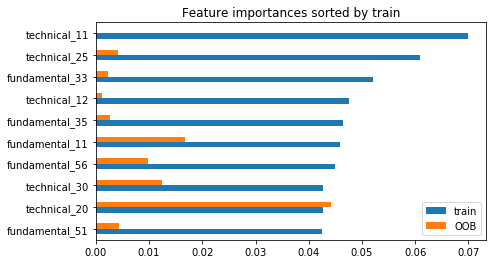

In [95]:
ax = imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

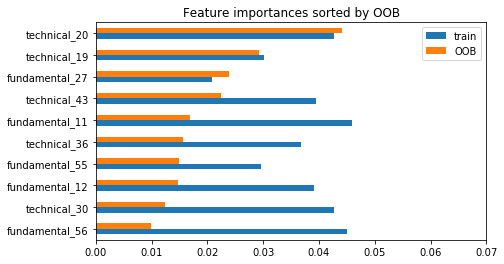

In [96]:
ax = imp.sort_values('OOB').tail(10).plot.barh(title='Feature importances sorted by OOB', 
                                               xlim=(0,0.07), figsize=(7,4))